In [22]:
import os
import csv
import math
import itertools

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from scipy import sparse
import networkx as nx

from mbi import (
    Dataset,
    FactoredInference,
    Domain,
    LocalInference,
    MixtureInference,
    PublicInference,
)

In [23]:
data = Dataset.load("data/compas_processed.csv", "data/compas_processed.json")

In [24]:
N = data.df.shape[0]
df = pd.DataFrame(columns=['col1','col2', 'score'])
idx = 0

In [25]:
# source: https://github.com/usnistgov/PrivacyEngCollabSpace/blob/master/tools/de-identification/Differential-Privacy-Synthetic-Data-Challenge-Algorithms/rmckenna/select-queries.ipynb

# calculate mutual info between every pair of attributes

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    # print(a,b,score)
    df.loc[idx] = [a,b,score]
    df.loc[idx+1] = [b,a,score]
    idx += 2

df = df.sort_values('score')


/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/1968762910.py:11: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/1968762910.py:11: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[n

In [26]:
df.head()

,col1,col2,score
29,is_violent_recid,sex,0.001448
28,sex,is_violent_recid,0.001448
65,is_violent_recid,race,0.001542
64,race,is_violent_recid,0.001542
18,sex,decile_score,0.002826


In [27]:
nodes = data.domain.attrs
weights = df[df.col1.isin(nodes) & df.col2.isin(nodes)]
weights.head()

,col1,col2,score
29,is_violent_recid,sex,0.001448
28,sex,is_violent_recid,0.001448
65,is_violent_recid,race,0.001542
64,race,is_violent_recid,0.001542
18,sex,decile_score,0.002826


In [28]:
G = nx.Graph()
G.add_nodes_from(nodes)

for e1, e2, w in zip(weights['col1'], weights['col2'], weights['score']):
    G.add_edge(e1, e2, weight=w)

mst = nx.maximum_spanning_tree(G)

es = list(mst.edges)
print(es)
print(len(es))

[('age', 'v_decile_score'), ('age', 'days_in_jail'), ('sex', 'c_days_from_compas'), ('decile_score', 'v_decile_score'), ('decile_score', 'is_recid'), ('priors_count', 'days_in_jail'), ('race', 'c_days_from_compas'), ('days_in_jail', 'c_days_from_compas'), ('is_violent_recid', 'is_recid')]
9


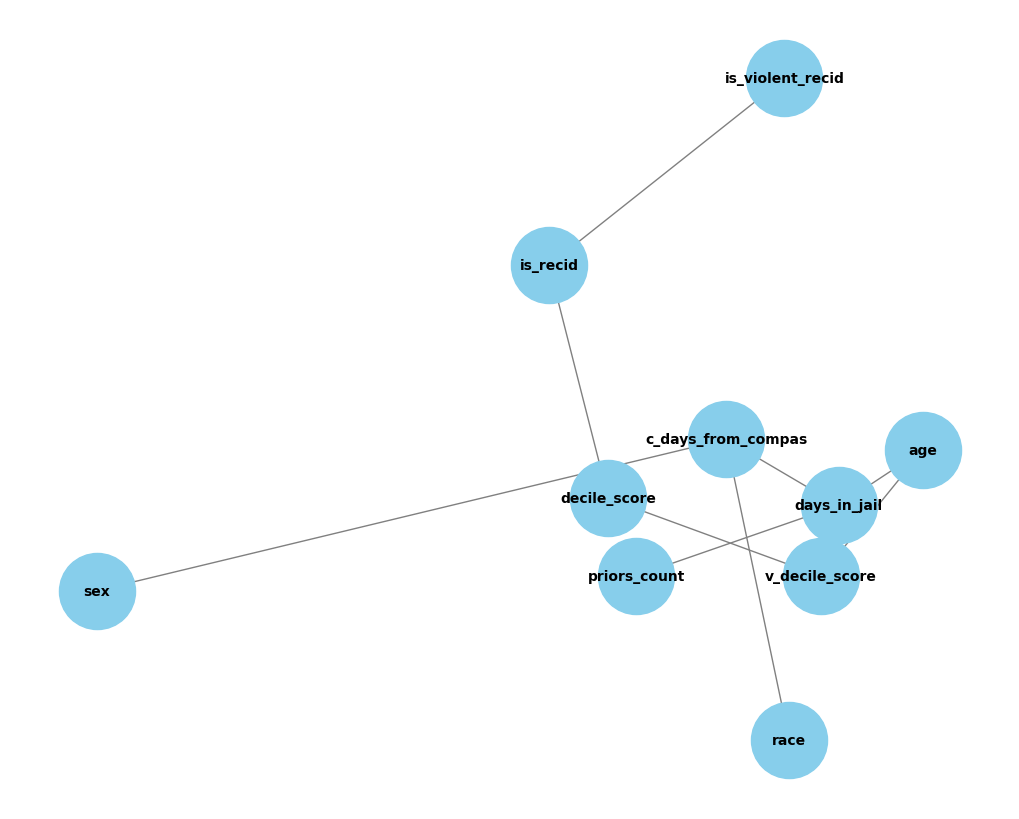

In [29]:
plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(mst, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()

In [30]:
df = pd.DataFrame(columns=['col1','col2', 'score', 'bound'])
idx = 0

entropies = {key: -1 for key in data.domain.attrs}

for attr in data.domain.attrs:
    # Calculate probabilities
    probabilities = data.df[attr].value_counts(normalize=True)
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    entropies[attr] = entropy

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    df.loc[idx] = [a,b,score,min(entropies[a],entropies[b])]
    idx += 1

df = df.sort_values('score')

df = df[df['score'] > df['bound'] * 0.1]
df

/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/2559294257.py:20: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/2559294257.py:20: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_89757/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[n

,col1,col2,score,bound
43,is_violent_recid,is_recid,0.056853,0.377407
5,age,c_days_from_compas,0.370974,3.216550
7,age,v_decile_score,0.397438,3.117339
22,decile_score,v_decile_score,0.495106,3.117339
35,days_in_jail,c_days_from_compas,0.539845,3.216550


In [31]:
tuple_list = list(zip(df['col1'], df['col2']))
es.extend(tuple_list)
es = list(set(es))
print(es)
print(len(es))

[('days_in_jail', 'c_days_from_compas'), ('decile_score', 'v_decile_score'), ('age', 'c_days_from_compas'), ('sex', 'c_days_from_compas'), ('priors_count', 'days_in_jail'), ('age', 'v_decile_score'), ('age', 'days_in_jail'), ('decile_score', 'is_recid'), ('is_violent_recid', 'is_recid'), ('race', 'c_days_from_compas')]
10


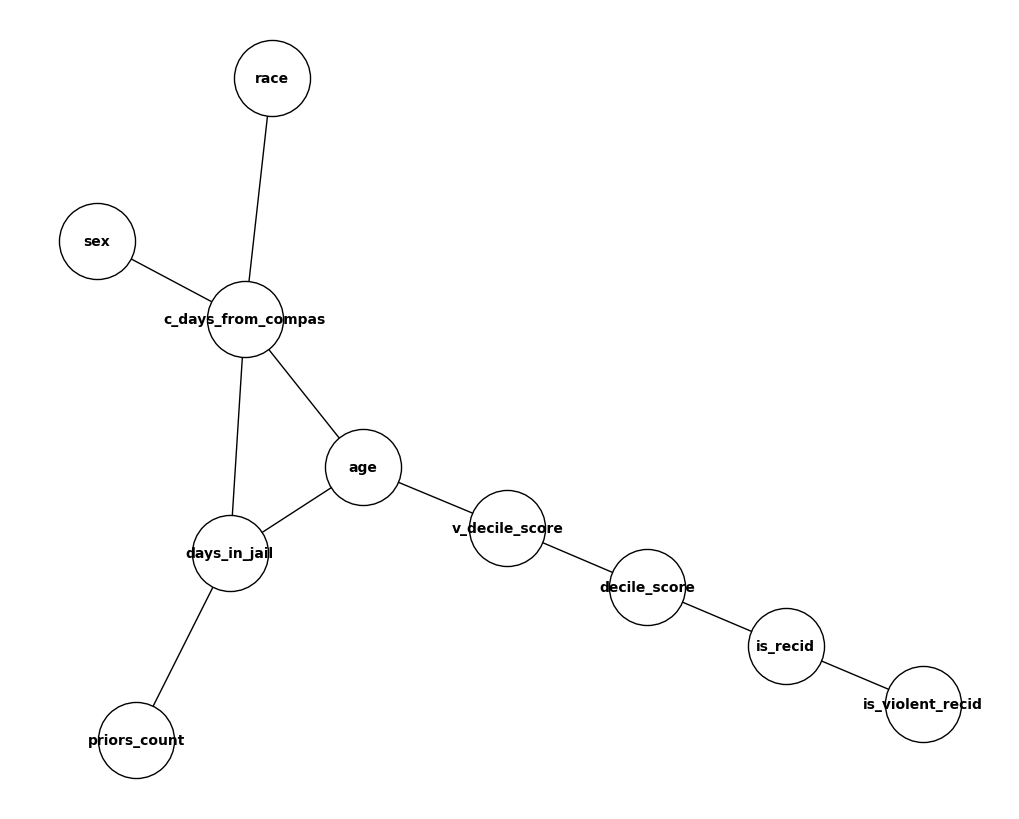

In [34]:
# Create a directed graph
G = nx.Graph()

# Add edges to the graph
G.add_edges_from(es)

plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.kamada_kawai_layout(G)  # Use spring layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='white', node_size=3000, font_size=10, font_weight='bold', edge_color='black', node_shape='o', edgecolors='black')

# Save the figure as a PDF
plt.savefig("paper/images/compas_mst.pdf", format="pdf", bbox_inches='tight')  # Specify the format as PDF

# Show the plot
plt.show()

In [33]:
cliques = list(nx.find_cliques(G))
for c in cliques:
    print(c)

['decile_score', 'is_recid']
['decile_score', 'v_decile_score']
['is_violent_recid', 'is_recid']
['c_days_from_compas', 'days_in_jail', 'age']
['c_days_from_compas', 'race']
['c_days_from_compas', 'sex']
['priors_count', 'days_in_jail']
['v_decile_score', 'age']
